<a href="https://colab.research.google.com/github/MickaelUFSC/visualDetection/blob/main/classico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importação das bibliotecas

In [ ]:
#importação das bibliotecas
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, interact_manual
import math
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
import copy
from time import sleep

Montando o Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Definição dos valores constantes para Kernels e Cores

In [ ]:
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

#define um kernel para abertura
kernel = np.ones((1,5),np.uint8)
kernel1 = np.ones((5,1),np.uint8)

#define um kernel para fechamento
kernel2 = np.ones((25,25),np.uint8)
kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))

# Faixas de cores para detecção
cor_menor = np.array((47, 61, 84))
cor_maior = np.array((56, 69, 95))

#Tamanho do vídeo
video_size = (400,500)

Função para detecção de cor utilizando o mouse.
Ajuda na hora de marcar uma faixa de cores para detectar.

In [ ]:
import cv2
import numpy as np

pressed = False
cores = []
# Função para capturar as coordenadas do clique do mouse
def capturar_cor(event, x, y, flags, param):
    global pressed, cores
    if event == cv2.EVENT_LBUTTONDOWN:
        pressed = True
    elif event == cv2.EVENT_LBUTTONUP:
        pressed = False
    elif event == cv2.EVENT_MOUSEMOVE:
        if pressed == True:
            cor = frame[y, x]
            #cores.append((cor[0],cor[1], cor[2]))
            cores.append((cor[2],cor[1], cor[0]))

# Inicialize a webcam ou carregue um vídeo
cap = cv2.VideoCapture('colors.mp4')   # 0 - webcam

cv2.namedWindow('Video')
cv2.setMouseCallback('Video', capturar_cor)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # Exibe o vídeo em tempo real
    cv2.imshow('Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        sleep(0.1)
    if cv2.waitKey(1) & 0xFF == 27:  # Pressione a tecla Esc para sair
        img = frame
        break

print(cores)
cap.release()
cv2.destroyAllWindows()


In [ ]:
print(min(cores) , max(cores))
cor_menor = np.array(min(cores))
cor_maior = np.array(max(cores))

(47, 61, 84) (56, 69, 95)


In [ ]:


#abre o video
cap = cv2.VideoCapture('colors.mp4')

if (cap.isOpened()== False):
    print("Error opening video  file")

#faz a leitura do vídeo
ret, frame = cap.read()

#altera as dimensões
frame = cv2.resize(frame, video_size)

#transforma em cinza
ref_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#ref_gray = cv2.equalizeHist(ref_gray)

# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(10,10))
ref_gray = clahe.apply(ref_gray)

background_subtractor = cv2.createBackgroundSubtractorKNN(
    history=50,  # Número de quadros passados a serem considerados
    dist2Threshold=400.0,  # Limiar para classificar um pixel como primeiro plano
    detectShadows=False  # Detectar sombras
)
frame_counter = 0
while(True):
    #Esse laço vai percorrer o video todo
    #Para sair é só apertar 'q' nas imagens que ele fecha

    ret, frame = cap.read()
    frame_counter += 1
    timer = cv2.getTickCount()
    try:
        frame = cv2.resize(frame, video_size)
    except:
        print("Fim")
        break
    # Aplicar os tratamentos a imagem
    #frame = cv2.medianBlur(frame,5)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = clahe.apply(gray)
    #gray = cv2.equalizeHist(gray)

    #Subtrai as imagens
    change = cv2.absdiff(gray, ref_gray)
    #blur = cv2.medianBlur(change,11)

    #aplicação de thresholds, fiz testes com diferentes tipos
    #dst = cv2.adaptiveThreshold(change,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,33,10)
    #dst = cv2.adaptiveThreshold(change,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,33,10)
    blur = cv2.GaussianBlur(change,(5,5),0)
    #th,dst = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th, dst = cv2.threshold(blur, 47, 255, cv2.THRESH_BINARY)

    #fechamento
    opening = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel)
    #Abertura
    opening1 = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel1)
    #Fechamento
    closing = cv2.morphologyEx(opening1, cv2.MORPH_CLOSE, kernel2)

    #Rotula as partes que sobraram
    imagem_rotulada = label(closing, connectivity=1)
    #print(len(regionprops(imagem_rotulada)))


    #if frame_counter%8 == 1:
    #    ref_gray = gray
        #print(frame_counter)
    if len(regionprops(imagem_rotulada)) == 0:
        #Atualiza a imagem de referência para o frame atual
        #Enquanto não for detectado nenhum rótulo
        ref_gray = gray

    for region in regionprops(imagem_rotulada):
        #Para cada rótulo é verificado a área e aplicado um box
        #a area da box é diferente da area da região
        #area box = largura*altura
        if region.area >= 1000 and region.area< 10000:
            minr, minc, maxr, maxc = region.bbox
            try :
                cv2.rectangle(frame, (minc,minr), (maxc, maxr), (0, 255, 0), 3)
                cv2.putText(frame, "area : " + str(int(region.area)), (minc,minr-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2);
            except:
                print("error")
        elif region.area >= 10000:
            try :
                minr, minc, maxr, maxc = region.bbox
                cv2.rectangle(frame, (minc,minr), (maxc, maxr), (255, 0, 0), 3)
                cv2.putText(frame, "area : " + str(int(region.area)), (minc,minr-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,100,0), 2);
                recorte = frame[minr:maxr, minc:maxc]
                topo = recorte[:(maxc - minc)*20//100, :]
                topo = cv2.cvtColor(topo, cv2.COLOR_BGR2RGB)
                #topo = cv2.pyrMeanShiftFiltering(topo, sp=3, sr=29)
                #cv2.imshow("recorte", recorte)
                #mask_azul = cv2.inRange(imagem_hsv, cor_menor, cor_maior)
                # pega contorno dos objetos da mascara
                #cnt_azul=cv2.findContours(mask_azul,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
                # ordena por area e pega os dois maiores objetos
                #cnt_azul=sorted(cnt_azul, key=cv2.contourArea, reverse=True)[:2]

                #if cnt_azul: # testa se encontrou objeto azul
                #    for cont in cnt_azul: # pecorre contoros encontrados
                        # pega centro e raio de um circo incrito do objeto
                #        (cx,cy),raio=cv2.minEnclosingCircle(cont)
                        # escreve nome da cor
                #        cv2.putText(frame,"Azul",(maxc//2, maxr//2),cv2.FONT_HERSHEY_COMPLEX,0.9,(255,0,0),1)
                        # Desenha circulo
                #        cv2.circle(frame,(maxc//2, maxr//2),int(raio),(255,0,0),3)
                #imagem_hsv = cv2.cvtColor(topo, cv2.COLOR_BGR2HSV)
                mascara = cv2.inRange(topo, cor_menor, cor_maior)
                mascara = cv2.morphologyEx(mascara, cv2.MORPH_CLOSE, kernel3)
                resultado = cv2.bitwise_and(topo, topo, mask=mascara)
                for region in regionprops(mascara):
                    if region.area > 200:
                        mr, mc, Mr, Mc = region.bbox
                        #print(region.area)
                        cv2.putText(frame, "Possui Azul", ((minc+maxc)//2, (minr+maxr)//2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2);
                #cv2.imshow("recorte", recorte)
                cv2.imshow("detecção de cor", resultado)
                #cv2.imshow("topo", topo)
            except:
                print("error")
        else:
            pass

    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);
    if ret == True:
        #mostra os resultados
        '''
        cv2.imshow("opening1", opening)
        cv2.imshow("opening2", opening1)
        cv2.imshow("closing", closing)
        '''
        result = cv2.bitwise_and(frame, frame, mask=closing)
        cv2.putText(result, "FPS : " + str(int(fps)), (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50,200,50), 2);
        #cv2.imshow("zero", change)
        #cv2.imshow("first", dst)
        #cv2.imshow("second", opening)
        #cv2.imshow("last", closing)
        cv2.putText(frame, "FPS : " + str(int(fps)), (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50,200,50), 2);
        cv2.imshow("Live", frame)


        if cv2.waitKey(25) & 0xFF == ord('q'):
            #Interrompe o laço
            img = gray
            break

    else:
        break

cap.release()
cv2.destroyAllWindows()

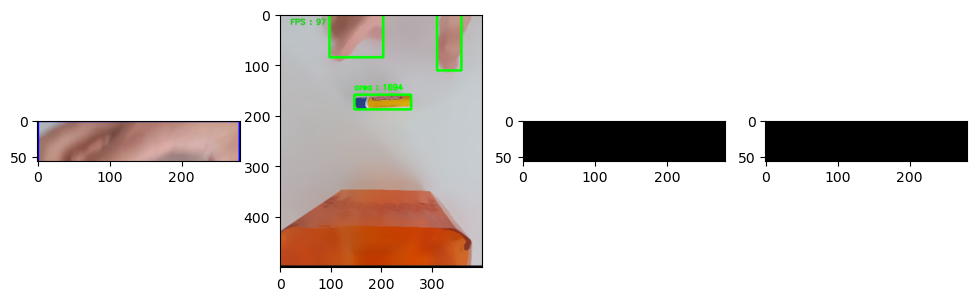

In [ ]:
plt.figure(figsize = (12,10))


plt.subplot(1, 4, 1)
plt.imshow(topo, 'gray')
plt.subplot(1, 4, 2)
plt.imshow(cv2.pyrMeanShiftFiltering(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), sp=11, sr=29))
plt.subplot(1, 4, 3)
plt.imshow(mascara, 'gray')
plt.subplot(1, 4, 4)
plt.imshow(resultado)

In [ ]:
for region in regionprops(mascara):
    if region.area > 600:
        print(region.area)

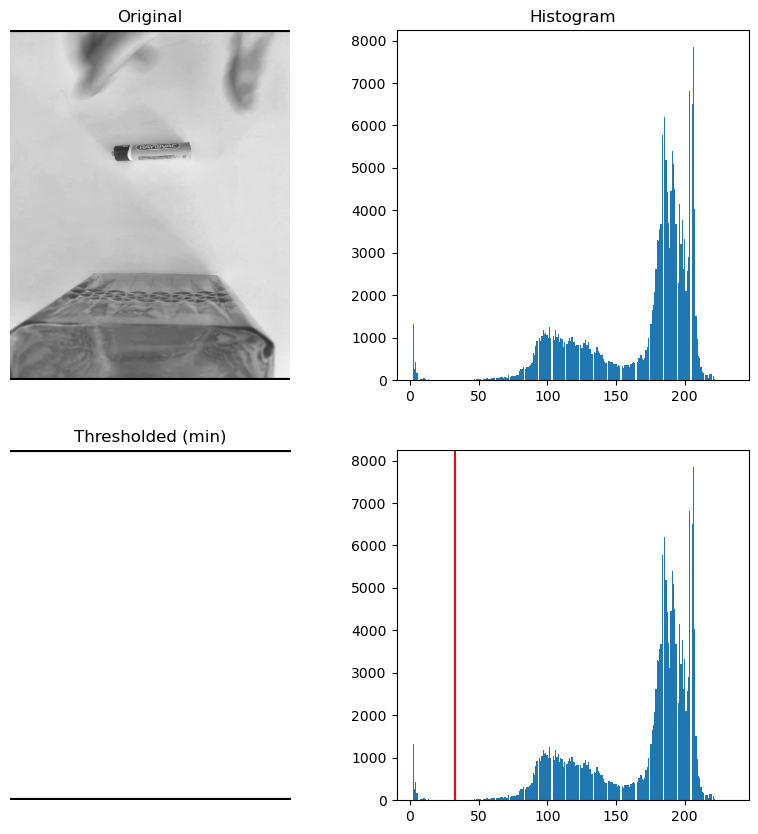

In [ ]:
from skimage.filters import threshold_minimum


image = img

thresh_min = threshold_minimum(image)
binary_min = image > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

C:\Users\micka\AppData\Local\Temp\ipykernel_12484\4253131187.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot(1, 4, 3, sharex=ax[0], sharey=ax[0])
C:\Users\micka\AppData\Local\Temp\ipykernel_12484\4253131187.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[3] = plt.subplot(1, 4, 4, sharex=ax[0], sharey=ax[0])


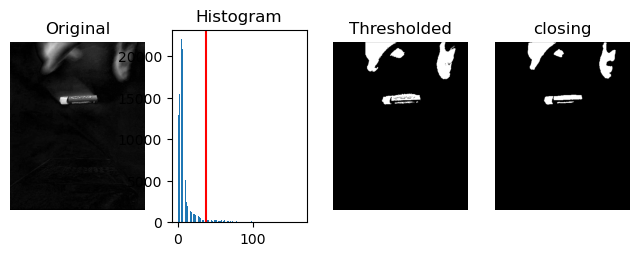

In [ ]:
from skimage.filters import threshold_otsu


image =  change
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=4, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2)
ax[2] = plt.subplot(1, 4, 3, sharex=ax[0], sharey=ax[0])
ax[3] = plt.subplot(1, 4, 4, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

ax[3].imshow(dst, cmap=plt.cm.gray)
ax[3].set_title('closing')
ax[3].axis('off')

plt.show()

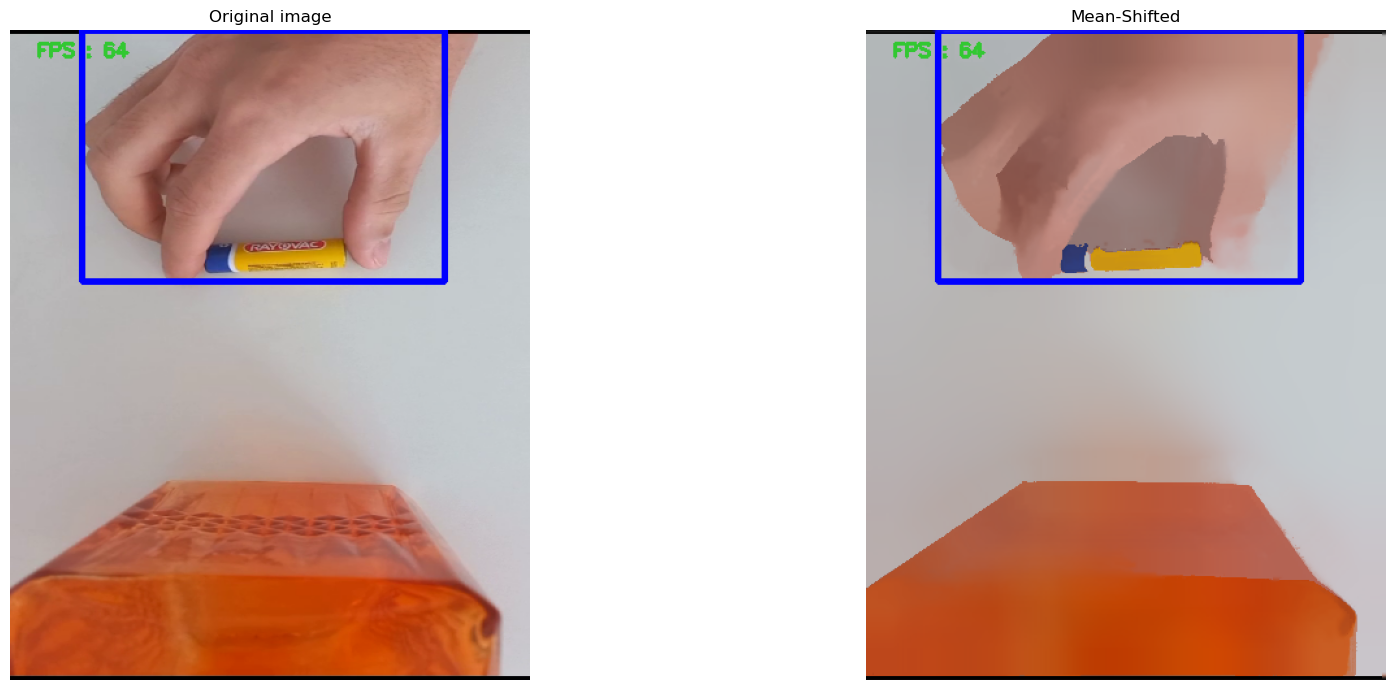

interactive(children=(IntSlider(value=21, description='spatialWindow', max=51, min=1, step=2), IntSlider(value…

In [ ]:
from ipywidgets import interact_manual
import matplotlib.pyplot as plt
import cv2

# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
image = frame
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def my_mean_sfift (spatialWindow = 21, colorWindow = 51):
    global image
    # The Mean Shift Filter performs the initial step of meanshift segmentation of an image.
    shifted = cv2.pyrMeanShiftFiltering(image, sp=spatialWindow, sr=colorWindow)

    fig, axes = plt.subplots(nrows = 1,ncols=2, figsize=(20, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[0].set_title('Original image')

    ax[1].imshow(shifted)
    ax[1].set_title('Mean-Shifted')

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

    interact_manual(my_mean_sfift, spatialWindow = (1, 51, 2), colorWindow = (1, 101, 2))

my_mean_sfift()

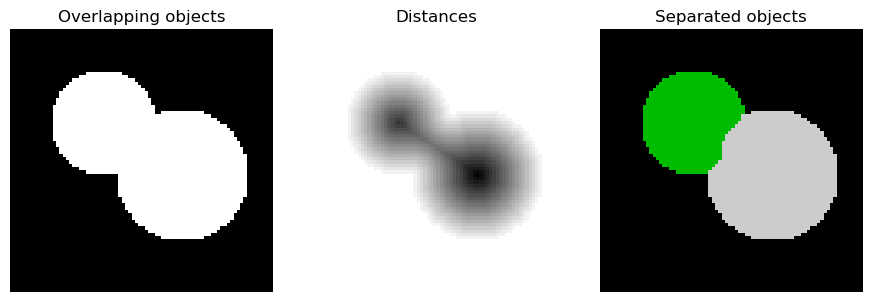

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80,80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()